In [2]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
import polars as pl
from pathlib import Path
from typing import List, Dict, Tuple
from tqdm import tqdm
import logging
import pyarrow as pa
import pyarrow.parquet as pq
import time
from datetime import datetime, timedelta
import sys

# QM9 and RDKit imports
from atomic_datasets import QM9
from atomic_datasets.utils.rdkit import is_molecule_sane
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdFingerprintGenerator
import selfies as sf

# Import our utility functions
#from utils_qm9 import get_shape_tanimoto
import pandas as pd
#from qm9_pair_generation import is_valency_ok
import utils_mol
from utils_mol import *

In [4]:
parquet_dir = '/data/lawrenh6/cache/test_new_code/qm9_pairs_per_mol_5_full' #qm9_pairs_0_001_7_18' #qm9_pairs_0_001_7_18' #qm9_pairs_test'
molecules_parquet = os.path.join(parquet_dir, 'molecules.parquet')
pairs_parquet = os.path.join(parquet_dir, 'pairs_val.parquet')

splits = ['train', 'val', 'test']
splits_parquet = {split: os.path.join(parquet_dir, f'pairs_{split}.parquet') for split in splits}
# # pairs_arrow = os.path.join(parquet_dir, 'pairs.arrow')

# # Read the Arrow file (IPC format)
# with pa.memory_map(pairs_parquet, "r") as source:
#     reader = ipc.RecordBatchStreamReader(source)
#     table = reader.read_all()

# Write it to Parquet
#pq.write_table(table, pairs_parquet)

molecules_df = pq.read_table(molecules_parquet).to_pandas()
pairs_df = pq.read_table(pairs_parquet).to_pandas()

split_pairs_df = {split: pq.read_table(splits_parquet[split]).to_pandas() for split in splits}

In [21]:
temp = '/data/lawrenh6/cache/qm9_pairs_0_001_7_18/pairs.parquet'
tempdf = pq.read_table(temp).to_pandas()
tempdf

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB
0,1,0,0.857143,0.152466,[1],[1]
1,212,0,0.857143,0.717042,"[0, 6]","[0, 1]"
2,18670,0,0.857143,0.791646,"[0, 9, 8, 10]","[0, 1, 2, 3]"
3,3,0,0.875000,0.338346,"[0, 3]","[0, 1]"
4,6,0,0.875000,0.617964,"[0, 2, 3, 4]","[0, 1, 2, 3]"
...,...,...,...,...,...,...
5480535,70437,131743,0.666667,0.367962,"[8, 15, 3, 2, 1, 0, 7, 4, 5, 13, 12, 14, 11, 10]","[2, 11, 1, 0, 6, 5, 7, 8, 3, 12, 15, 14, 10, 9]"
5480536,131743,106172,0.666667,0.486819,"[3, 12, 2, 11, 1, 0, 6, 5, 4, 13, 7, 8, 15, 14...","[5, 16, 8, 19, 4, 3, 2, 7, 6, 17, 1, 0, 10, 12..."
5480537,131743,106185,0.666667,0.353354,"[3, 12, 2, 11, 1, 7, 6, 5, 4, 13, 0, 10, 9, 14]","[5, 14, 8, 17, 4, 3, 2, 7, 6, 15, 1, 10, 11, 13]"
5480538,33516,131743,0.675676,0.427447,"[8, 14, 5, 11, 6, 7, 2, 3, 4, 9, 10, 1, 12]","[2, 11, 3, 12, 4, 5, 6, 0, 1, 10, 9, 7, 13]"


(array([1.000e+00, 9.000e+00, 2.890e+02, 2.722e+03, 9.203e+03, 8.688e+03,
        6.962e+03, 2.403e+03, 8.300e+01, 5.000e+00]),
 array([0.0246 , 0.06679, 0.10898, 0.15117, 0.19336, 0.23555, 0.27774,
        0.31993, 0.36212, 0.40431, 0.4465 ]),
 <BarContainer object of 10 artists>)

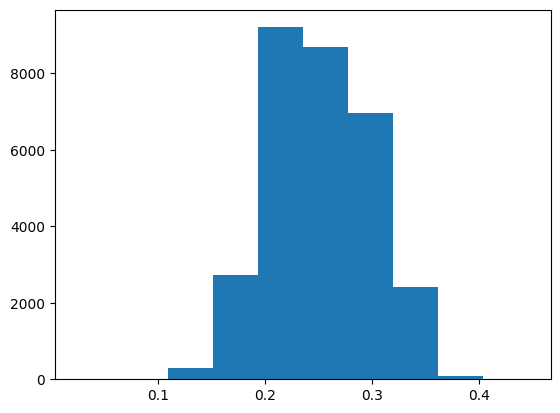

In [19]:
import matplotlib.pyplot as plt
plt.hist(molecules_df['gap'])

In [14]:
import torch
torch.sum(torch.tensor(molecules_df['val']==True))

tensor(13174)

In [15]:
molecules_df.shape

(131744, 18)

In [18]:
split = 'train'
split_pairs_df[split] #['molecule_a_idx']
#molecules_df.iloc[split_pairs_df[split]['molecule_a_idx']]

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB
0,1,0,0.857143,0.152466,[1],[1]
1,212,0,0.857143,0.717042,"[0, 6]","[0, 1]"
2,18670,0,0.857143,0.791646,"[0, 9, 8, 10]","[0, 1, 2, 3]"
3,3,0,0.875000,0.338346,"[0, 3]","[0, 1]"
4,6,0,0.875000,0.617964,"[0, 2, 3, 4]","[0, 1, 2, 3]"
...,...,...,...,...,...,...
5480535,70437,131743,0.666667,0.367962,"[8, 15, 3, 2, 1, 0, 7, 4, 5, 13, 12, 14, 11, 10]","[2, 11, 1, 0, 6, 5, 7, 8, 3, 12, 15, 14, 10, 9]"
5480536,131743,106172,0.666667,0.486819,"[3, 12, 2, 11, 1, 0, 6, 5, 4, 13, 7, 8, 15, 14...","[5, 16, 8, 19, 4, 3, 2, 7, 6, 17, 1, 0, 10, 12..."
5480537,131743,106185,0.666667,0.353354,"[3, 12, 2, 11, 1, 7, 6, 5, 4, 13, 0, 10, 9, 14]","[5, 14, 8, 17, 4, 3, 2, 7, 6, 15, 1, 10, 11, 13]"
5480538,33516,131743,0.675676,0.427447,"[8, 14, 5, 11, 6, 7, 2, 3, 4, 9, 10, 1, 12]","[2, 11, 3, 12, 4, 5, 6, 0, 1, 10, 9, 7, 13]"


In [18]:
split_pairs_df['train']

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB
0,1,0,0.857143,0.152466,[1],[1]
1,212,0,0.857143,0.717042,"[0, 6]","[0, 1]"
2,18670,0,0.857143,0.791646,"[0, 9, 8, 10]","[0, 1, 2, 3]"
3,3,0,0.875000,0.338346,"[0, 3]","[0, 1]"
4,6,0,0.875000,0.617964,"[0, 2, 3, 4]","[0, 1, 2, 3]"
...,...,...,...,...,...,...
5480535,70437,131743,0.666667,0.367962,"[8, 15, 3, 2, 1, 0, 7, 4, 5, 13, 12, 14, 11, 10]","[2, 11, 1, 0, 6, 5, 7, 8, 3, 12, 15, 14, 10, 9]"
5480536,131743,106172,0.666667,0.486819,"[3, 12, 2, 11, 1, 0, 6, 5, 4, 13, 7, 8, 15, 14...","[5, 16, 8, 19, 4, 3, 2, 7, 6, 17, 1, 0, 10, 12..."
5480537,131743,106185,0.666667,0.353354,"[3, 12, 2, 11, 1, 7, 6, 5, 4, 13, 0, 10, 9, 14]","[5, 14, 8, 17, 4, 3, 2, 7, 6, 15, 1, 10, 11, 13]"
5480538,33516,131743,0.675676,0.427447,"[8, 14, 5, 11, 6, 7, 2, 3, 4, 9, 10, 1, 12]","[2, 11, 3, 12, 4, 5, 6, 0, 1, 10, 9, 7, 13]"


In [10]:
split_pairs_df['val']

,molecule_a_idx,molecule_b_idx,split,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,rmsd,matching_time
0,0,15066,val,0.483871,0.256126,"[4, 14, 13, 5, 6, 15, 16, 8, 18, 17, 1, 0, 9, ...","[5, 15, 16, 6, 8, 20, 19, 7, 17, 18, 1, 0, 9, ...",1.659078,0.024720
1,0,1729,val,0.500000,0.462630,"[6, 7, 5, 8, 18, 17, 4, 14, 13, 3, 1, 2, 11, 1...","[1, 0, 3, 2, 11, 10, 4, 13, 14, 5, 7, 6, 16, 1...",1.718522,0.007482
2,0,11411,val,0.529412,0.077453,"[6, 15, 16, 5, 4, 14, 13, 3, 1, 0, 9, 2, 11, 1...","[6, 15, 16, 5, 4, 13, 14, 3, 1, 0, 9, 2, 11, 1...",0.663744,0.037244
3,0,13770,val,0.529412,0.361274,"[6, 7, 15, 16, 5, 8, 18, 17, 1, 0, 9, 2, 3, 4,...","[7, 8, 17, 18, 6, 5, 15, 16, 1, 0, 9, 2, 3, 4,...",1.444211,0.004375
4,0,2848,val,0.531250,0.491837,"[0, 9, 1, 2, 11, 10, 3, 12, 4, 14, 13, 5, 6, 7...","[3, 13, 2, 4, 15, 14, 1, 12, 0, 10, 9, 7, 6, 5...",2.020508,0.024048
...,...,...,...,...,...,...,...,...,...
87445,17489,22,val,0.486486,0.214503,"[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 4, 12, 13, 7]","[6, 16, 15, 5, 14, 2, 7, 8, 17, 3, 4, 13, 12, 1]",0.379020,0.008406
87446,17489,8369,val,0.600000,0.024974,"[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 13, 7, 14]","[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 12, 7, 13]",0.035607,0.010965
87447,17489,12004,val,0.609756,0.433898,"[2, 9, 10, 3, 6, 7, 14, 1, 5, 4, 12, 13]","[0, 10, 9, 1, 5, 6, 16, 4, 3, 2, 12, 13]",0.943191,0.092540
87448,17489,3705,val,0.611111,0.130175,"[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 13, 7, 14]","[5, 13, 14, 6, 15, 7, 3, 4, 12, 2, 11, 8, 16]",0.079527,0.000468


In [11]:
split_pairs_df['test']

,molecule_a_idx,molecule_b_idx,split,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,rmsd,matching_time
0,17490,23849,test,0.516129,0.439583,"[0, 10, 9, 1, 13, 12, 2, 3, 4, 17, 16, 5, 8, 2...","[0, 8, 7, 1, 11, 10, 2, 3, 4, 15, 14, 5, 6, 19...",1.294384,0.001963
1,17490,24987,test,0.545455,0.477012,"[6, 19, 5, 3, 16, 2, 14, 1, 13, 0, 10, 9, 11, ...","[7, 20, 5, 3, 16, 2, 15, 1, 12, 0, 10, 9, 11, ...",1.467854,0.006763
2,17490,18432,test,0.562500,0.457944,"[6, 19, 20, 5, 3, 2, 14, 1, 13, 0, 10, 9, 11, ...","[5, 19, 18, 4, 3, 2, 13, 1, 10, 0, 8, 7, 9, 11...",1.512994,0.006078
3,17490,18707,test,0.571429,0.335540,"[0, 10, 9, 1, 13, 12, 2, 3, 4, 17, 16, 5, 8, 1...","[0, 9, 8, 1, 12, 11, 2, 3, 4, 16, 15, 5, 6, 13...",0.900471,0.001780
4,17490,21841,test,0.571429,0.295904,"[4, 17, 3, 5, 2, 14, 15, 1, 13, 0, 10, 9, 11, ...","[4, 16, 3, 5, 2, 13, 14, 1, 12, 0, 9, 8, 10, 1...",0.038527,0.004269
...,...,...,...,...,...,...,...,...,...
64370,30364,29815,test,0.500000,0.373162,"[0, 10, 9, 1, 8, 2, 13, 3, 6, 7, 18, 17, 4, 16...","[0, 10, 9, 1, 4, 8, 18, 5, 3, 2, 12, 14, 6, 16...",1.679822,0.140141
64371,30364,27888,test,0.516129,0.306255,"[0, 10, 9, 1, 2, 13, 12, 3, 6, 7, 8, 18, 5, 17...","[0, 10, 9, 1, 2, 13, 12, 3, 7, 6, 5, 17, 8, 18...",1.318957,0.092842
64372,30364,17555,test,0.552632,0.479056,"[3, 14, 4, 2, 13, 1, 7, 8, 18, 0, 10, 9, 11, 12]","[3, 12, 2, 4, 13, 5, 8, 7, 18, 6, 17, 16, 15, 14]",1.123980,0.003342
64373,30364,19862,test,0.578947,0.312285,"[0, 10, 9, 1, 2, 13, 12, 3, 4, 16, 15, 14, 7, ...","[0, 10, 9, 1, 2, 12, 13, 3, 4, 15, 16, 14, 7, ...",1.608165,0.098874
